# Multi-quDit operations and entropies
This is an ongoing project-notebook for symbolic programming manipulation of arbitrary number of qudits based on sympy.

Main todo's:

Partial Tracing for arbitrary systems and subsystems.

Parallel manipulation in matrix form and symbolic form(dirac notation).

Quantum entropy calculations.

In [1]:
from sympy.matrices import Matrix
from sympy.physics.quantum import TensorProduct, qapply, Dagger, OrthogonalKet, OrthogonalBra
from sympy.interactive import printing
printing.init_printing(use_latex = True)
from sympy import *

# Development of the matrix part
Todo's:

-in the init method should be check if the matrix satisfies the density matrix conditions

-test how it works with symbols(i.e. parameters)(so far ok)

-test partial trace result with examples

-at this point the partial trace calculation mod is not efficient but an application of the partial trace definition. We can do it more efficient by simplifying using the zeros of the orthonormal basis as in https://digitalcommons.calpoly.edu/cgi/viewcontent.cgi?referer=&httpsredir=1&article=1038&context=physsp#:~:text=In%20SymPy%2C%20the%20density%20operator,only%20work%20for%20Qubit%20objects.&text=We%20form%20a%20Density%20object%20made%20up%20of%20general%20ket%20states

In [2]:
class density_matrix:
    """
    -the density matrix as a sympy matrix
    
    -the dimensions of the subspaces in list
    for example if its a qubit times qubit which means 2x2 
    hence 4 dimensional hilbert space the dimentions will be the list [2,2]
    
    """
    def __init__(self, matrix, dims):
        self.matrix = matrix
        self.dims = dims
        self.d = sum(dims)
    def __mul__(self,other):
        return density_matrix(self.matrix*other.matrix)
    def __add__(self,other):
        return density_matrix(self.matrix+other.matrix)
    def __sub__(self,other):
        return density_matrix(self.matrix-other.matrix)
    def __floordiv__(self,other):
        """
        I use the floordiv // operation for tensor product notation  
        """
        return TensorProduct(self.matrix,other.matrix)
    def __mod__(self,quDits_to_be_dropped):
        """
        i use the mod % symbol for finding the partial trace by mentioning which qubits will be traced out
        for example let's say that we have a qubit times a qutrit times a qubit(a 2*3*2=A*B*C hilbert space) and 
        we want to trace out the A and the C states, i.e. we want to get the substate B. We get that by writing
        density_matrix%[0,2] meaning trace out the first and the third qubit.
        """
        def tracors(dimensions_list, to_trace_out):
            trace_list = []
            d = eye(dimensions_list[to_trace_out])
            for i in range(dimensions_list[to_trace_out]):
                m = Matrix([[1]])
                for j in range(len(dimensions_list)):
                    if j==to_trace_out:
                        m = TensorProduct(m,d.col(i))
                    else:
                        m = TensorProduct(m,eye(dimensions_list[j]))
                trace_list.append(m)
            return trace_list
        def trace_out_one(operator,tracor_list):
            x,y= shape(tracor_list[0])
            n=int(self.d/int(x/y))
            s = zeros(n,n)
            for i in tracor_list:
                s+=Dagger(i)*operator*i
            return s
        m = self.matrix
        dims = (self.dims).copy()
        quDits_to_be_dropped.sort()
        q = quDits_to_be_dropped.copy()
        for i in range(len(quDits_to_be_dropped)):
            m = trace_out_one(m, tracors(dims,q[0]))
            dims.remove(dims[q[0]])
            q = q[1:]
            q[:] = [x - 1 for x in q]
        return density_matrix(m,dims)
    def shape(self):
        return shape(self.matrix_form)
    def get_matrix(self):
        return self.matrix
    def show(self):
        #display("Matrix form:")
        display(self.matrix)
    def dagger(self):
        return Dagger(self.matrix)

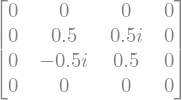

In [3]:
example1 = density_matrix((1/2)*Matrix([[0,0,0,0],[0,1,1j,0],[0,-1j,1,0],[0,0,0,0]]),[2,2])
example1.show()

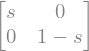

In [4]:
s = symbols('s')
example2 = density_matrix(Matrix([[s,0],[0,1-s]]),[2])
example2.show()

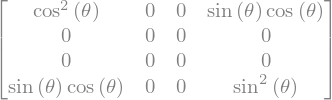

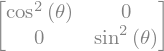

In [62]:
theta = symbols('theta')
example3 = density_matrix(Matrix([[(cos(theta))**2,0,0,cos(theta)*sin(theta)],[0,0,0,0],[0,0,0,0],[cos(theta)*sin(theta),0,0,(sin(theta))**2]]),[2,2])
example3.show()
(example3%[0]).show()

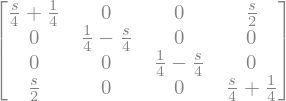

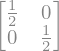

In [65]:
werner_state = density_matrix(Matrix([[(1+s)/4,0,0,s/2],[0,(1-s)/4,0,0],[0,0,(1-s)/4,0],[s/2,0,0,(1+s)/4]]),[2,2])
werner_state.show()
(werner_state%[1]).show()

# Development of the symbolic dirac part

In [2]:
class qinfo_state:
    """
    for now it assumes you are creating a valid state
    """
    def __init__(self, matrix):
        """
        From the one to another?
        """
        self.matrix_form = matrix_form
        self.dirac_form = dirac_form
    def shape(self):
        return shape(self.matrix_form)
    def get_matrix(self):
        return self.matrix_form
    def get_dirac(self):
        return self.dirac_form
    def show(self):
        display("In Matrix form:")
        display(self.get_matrix())
        display("In Dirac form:")
        display(qapply(self.get_dirac()))
    def dagger(self):
        return qinfo_state(Dagger(self.matrix_form),Dagger(self.dirac_form))
    def __mul__(self,other):
        if is_ket(other):
            pass
    def fshow(self):
        """
        print as ket=matrix 
        """
        pass

# other functions that my be used

In [16]:


def is_qudit(system):
    """
    checks if a qinfostate is a qudit or not, meaning ket or bra not density operator form. this may need change in 
    the future in order to be consistent with mathematical definitions
    """
    return (bool(system.shape()[0]==1) ^ bool(system.shape()[1]==1))

def is_ket(system):
    """
    checks if a qudit instance is a ket. If it is, it returns True, if it's not it returns False
    """
    if is_qudit(system):
        return system.shape()[1]==1
    else:
        raise TypeError("This is not a quDit state. Therefore it can not be a ket.")
    
def is_bra(system):
    """
    checks if a qudit is a bra. If it is, it returns True, if it's not it returns False
    """
    if is_qudit(system):
        return system.shape()[0]==1
    else:
        raise TypeError("This is not a quDit state. Therefore it can not be a ket.")

def is_density_state(system):
    """
    checks if the system is a density state i.e. not a qudit(ket or bra)
    
    for now I use the is_qudit function but ideally it would be separate checker
    """
    if not is_qudit(system):
        return True
    else:
        return False

def inner_product(quditA, quditB):
    pass

def outer_product(stateA,stateB):
    return qinfo_state(tensor_product(stateA,stateB.dagger()).get_matrix(),stateA.get_dirac()*stateB.dagger().get_dirac())

def identity_qinfo_state(d):
    """
    returns a qinfostate instance which is the identity matrix of certain dimensions
    """
    return qinfostate(eye(d),)